In [1]:
%matplotlib inline
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import datetime
import logging
import itertools
# Set the style for plots
plt.style.use('ggplot')

In [2]:
# Read the data from a csv file and convert the 'Date' column to datetime format
df = pd.read_csv('sp500_index.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df.tail()

,Date,S&P500
2512,2023-05-31,4179.83
2513,2023-06-01,4221.02
2514,2023-06-02,4282.37
2515,2023-06-05,4273.79
2516,2023-06-06,4283.85


In [4]:
# Generate a profiling report for the data frame
profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

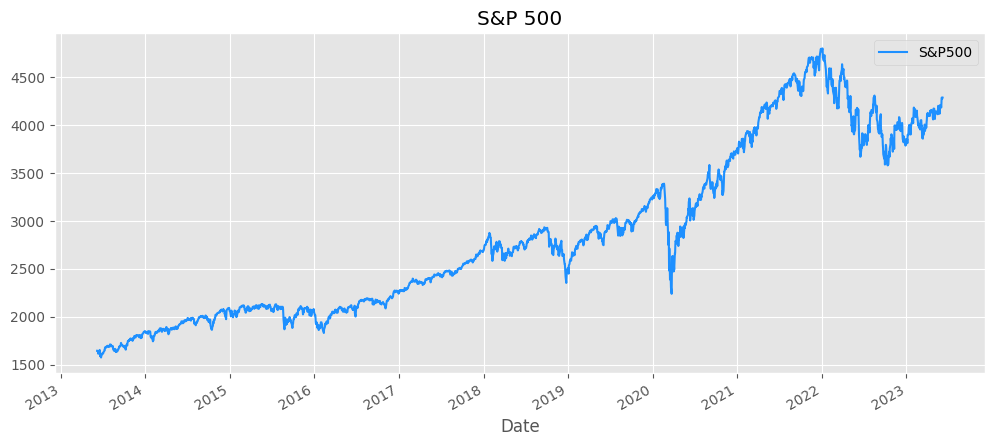

In [5]:
# Plot the 'S&P500' column against the 'Date' column
df.plot(style='-',
        figsize=(12,5),
        x='Date',
        y='S&P500',
        title='S&P 500',
        color='dodgerblue')
plt.show()

In [6]:
# Rename the columns for compatibility with Prophet library
df_prophet = df.rename(columns={'Date':'ds',
                                'S&P500':'y'})

In [7]:
df_prophet.head()

,ds,y
0,2013-06-07,1643.38
1,2013-06-10,1642.81
2,2013-06-11,1626.13
3,2013-06-12,1612.52
4,2013-06-13,1636.36


In [8]:
%%time
# Create and fit a Prophet model with specified parameters
model = Prophet(interval_width=0.95, weekly_seasonality=False)
# Add US holidays
model.add_country_holidays(country_name='US')
model.fit(df_prophet)

11:47:54 - cmdstanpy - INFO - Chain [1] start processing
11:47:55 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 172 ms, sys: 23.6 ms, total: 195 ms
Wall time: 1.11 s


In [9]:
# Create dataframe for 30 business days ahead, make future predictions and display the last 5 rows of the forecast data frame
future = model.make_future_dataframe(periods=30, freq='B')
forecast = model.predict(future)
forecast.tail()

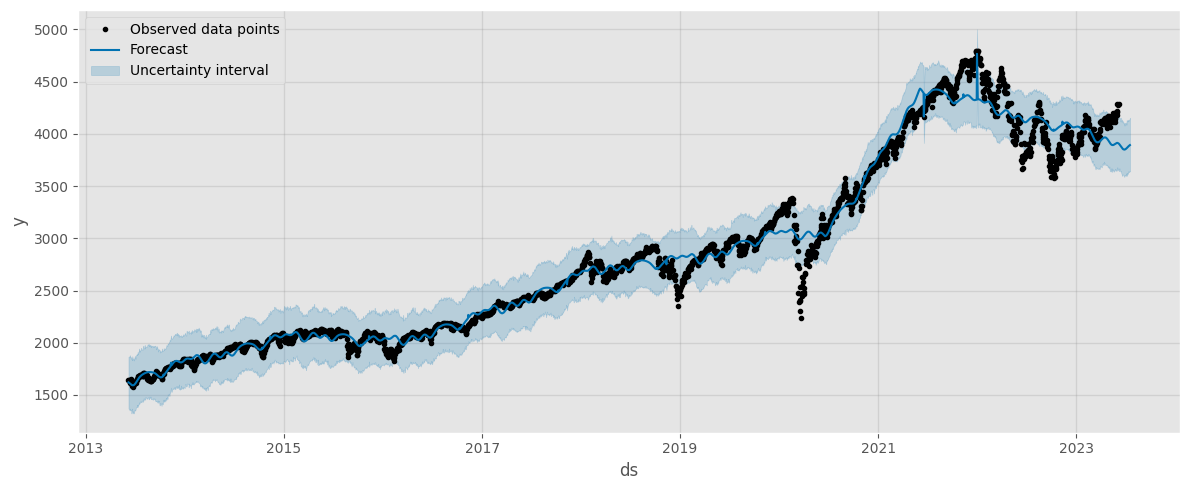

In [11]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model.plot(forecast, ax=ax, include_legend=True)
plt.show()

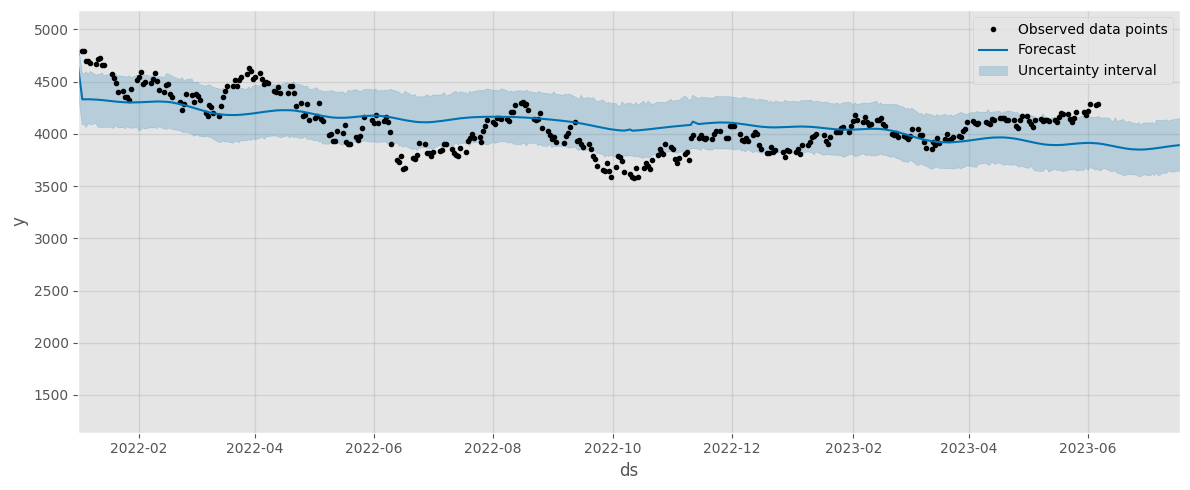

In [12]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model.plot(forecast, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

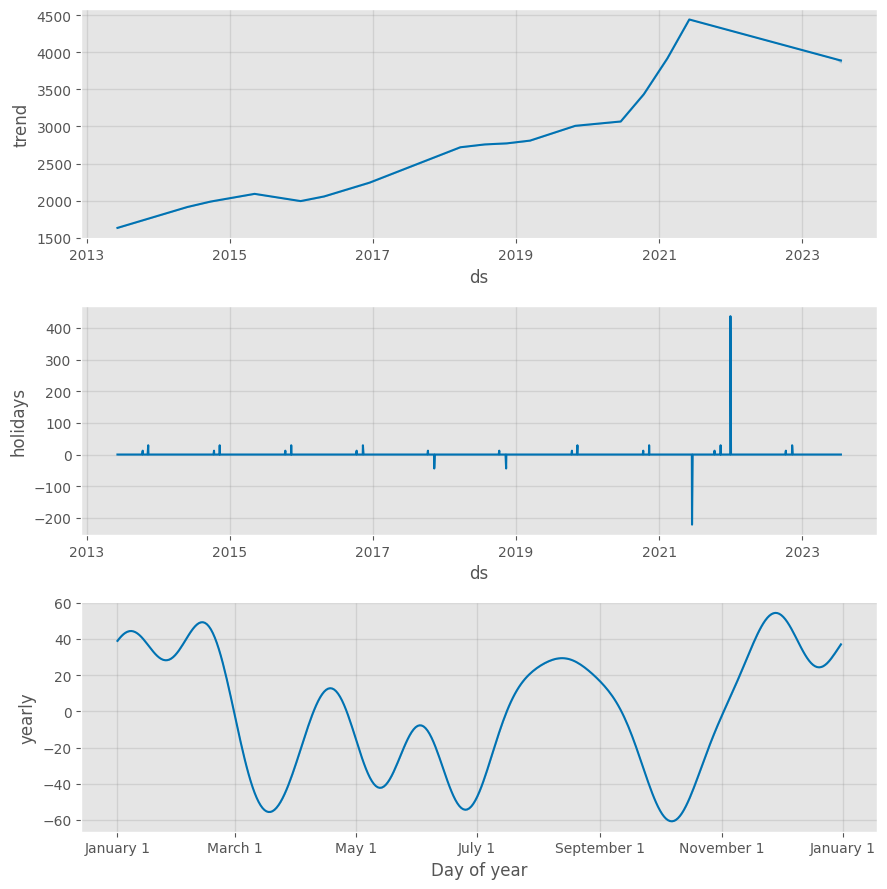

In [13]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model.plot_components(forecast)
plt.show()

In [14]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv = cross_validation(model, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_cv_p = performance_metrics(forecast_cv)
forecast_cv_p.head()

CPU times: user 422 ms, sys: 29.2 ms, total: 451 ms
Wall time: 14.6 s


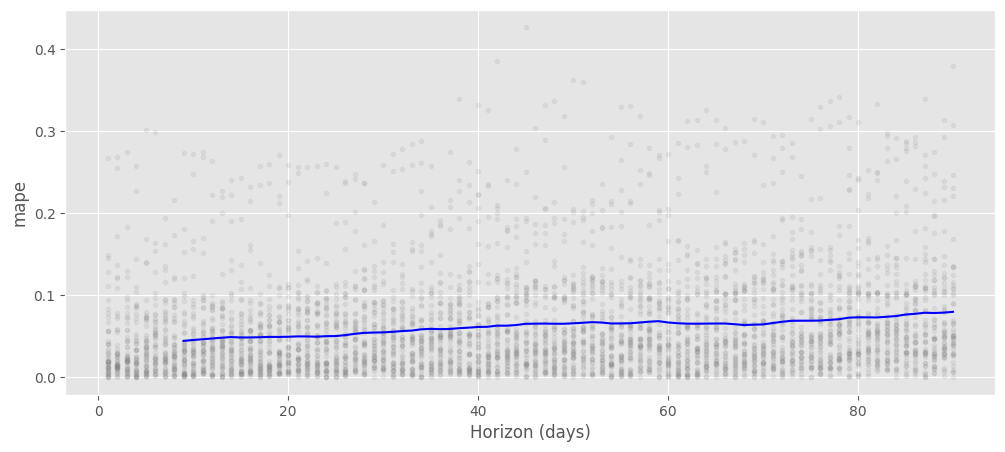

In [16]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv, ax=ax, metric='mape')
plt.show()

In [ ]:
%%time
# Perform grid search to find optimal hyperparameters for the model and display tuning results and best parameters found.
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    logging.getLogger("cmdstanpy").disabled = True 
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m , horizon='30 days', parallel="processes")
    logging.getLogger("cmdstanpy").disabled = False
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [20]:
%%time
# Create and fit a Prophet model with best parameters from grid search
model_best = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
# Add US holidays
model_best.add_country_holidays(country_name='US')
model_best.fit(df_prophet)
forecast_best = model_best.predict(future)

11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 924 ms, sys: 363 ms, total: 1.29 s
Wall time: 1.5 s


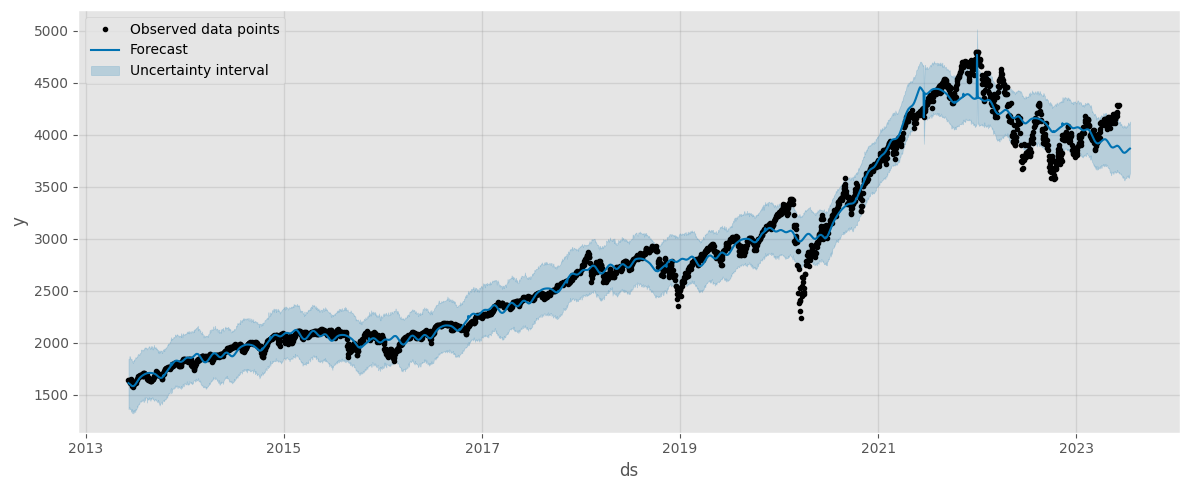

In [21]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model_best.plot(forecast_best, ax=ax, include_legend=True)
plt.show()

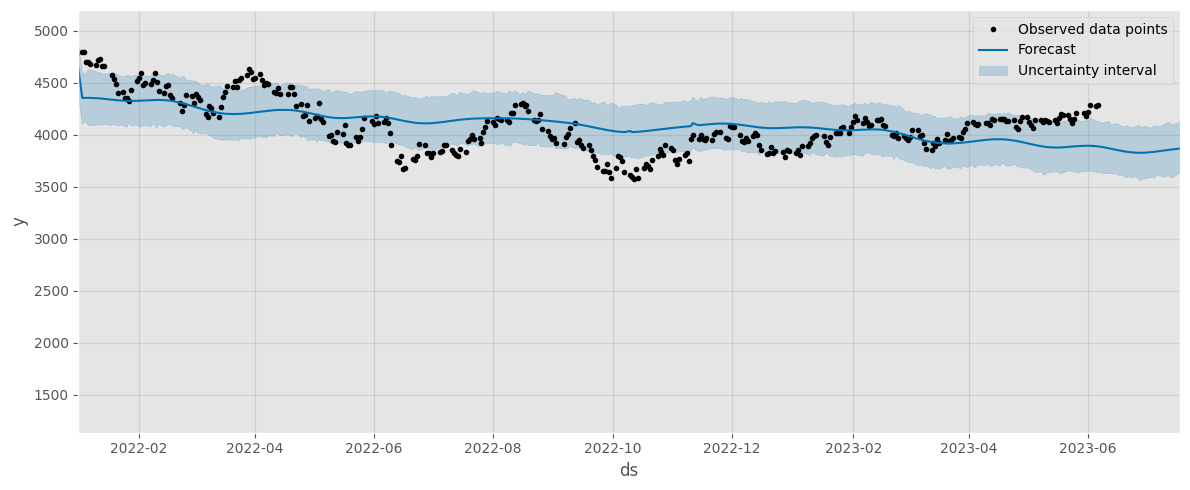

In [22]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast_best['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_best.plot(forecast_best, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

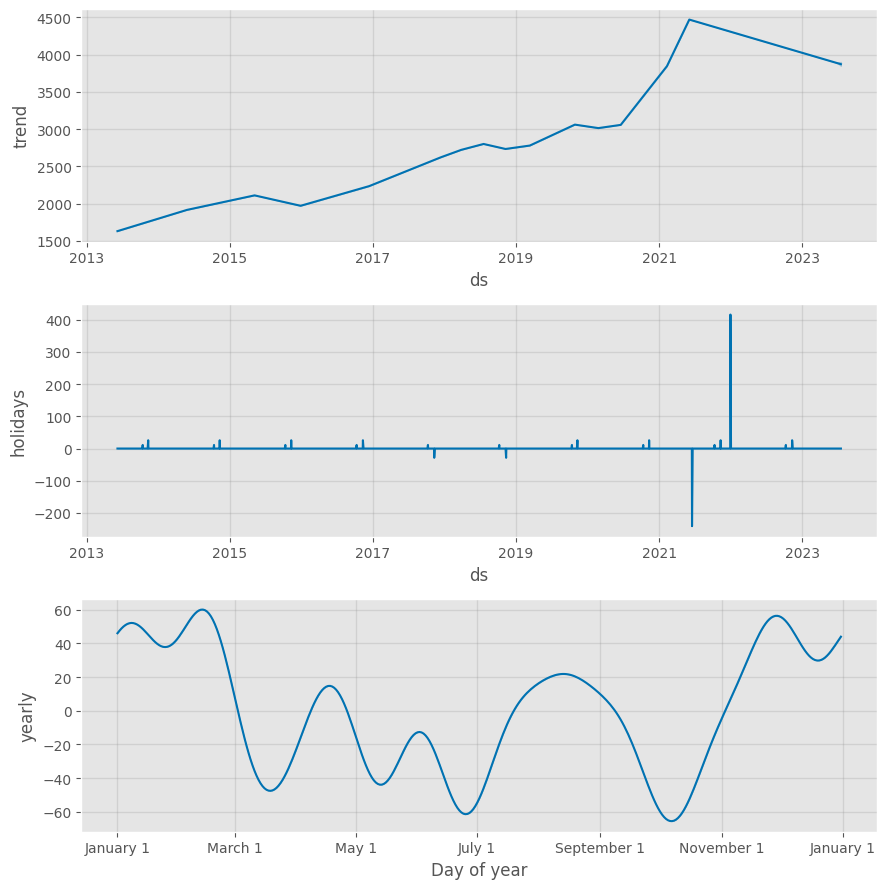

In [23]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model_best.plot_components(forecast_best)
plt.show()

In [24]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_best = cross_validation(model_best, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_best_perf = performance_metrics(forecast_cv_best)
forecast_best_perf.head()

CPU times: user 361 ms, sys: 71.9 ms, total: 433 ms
Wall time: 21.4 s


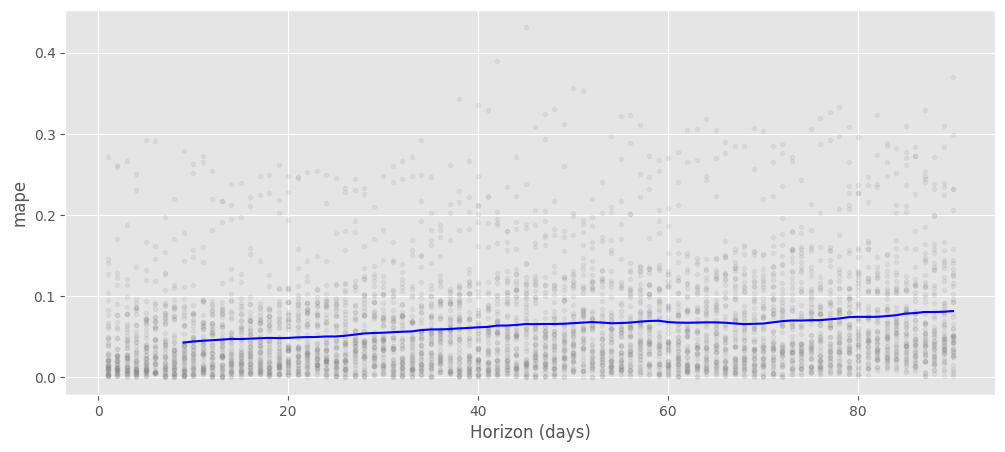

In [26]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_best, ax=ax, metric='mape')
plt.show()

In [27]:
%%time
# Create a Prophet model with best parameters from grid search and custom seasonality
model_best_season = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
model_best_season.add_seasonality(name='yearly', period=365, fourier_order=8)
# Add US holidays
model_best_season.add_country_holidays(country_name='US')
model_best_season.fit(df_prophet)
forecast_best_season = model_best_season.predict(future)

11:58:51 - cmdstanpy - INFO - Chain [1] start processing
11:58:51 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 930 ms, sys: 335 ms, total: 1.27 s
Wall time: 1.4 s


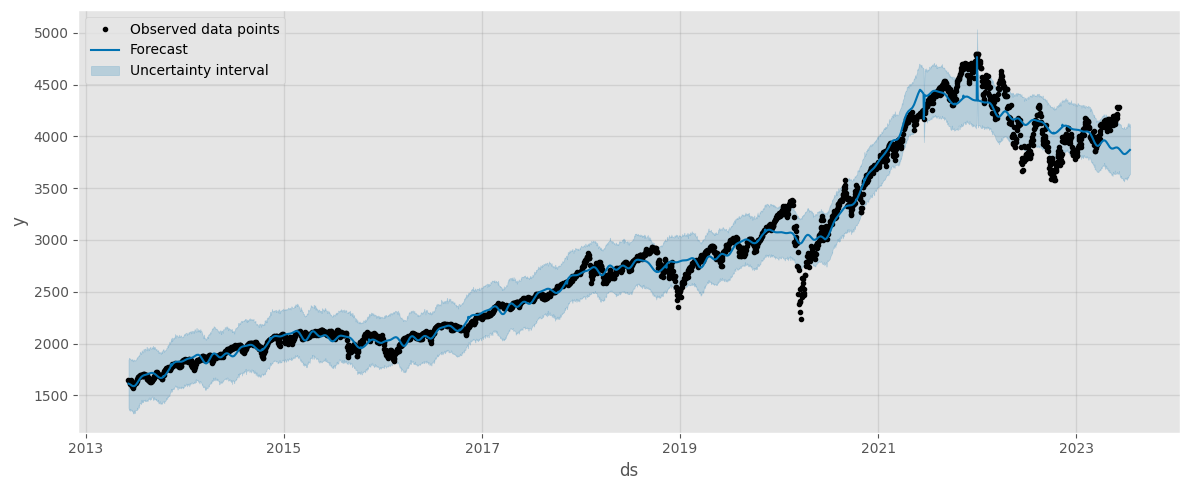

In [28]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model_best_season.plot(forecast_best_season, ax=ax, include_legend=True)
plt.show()

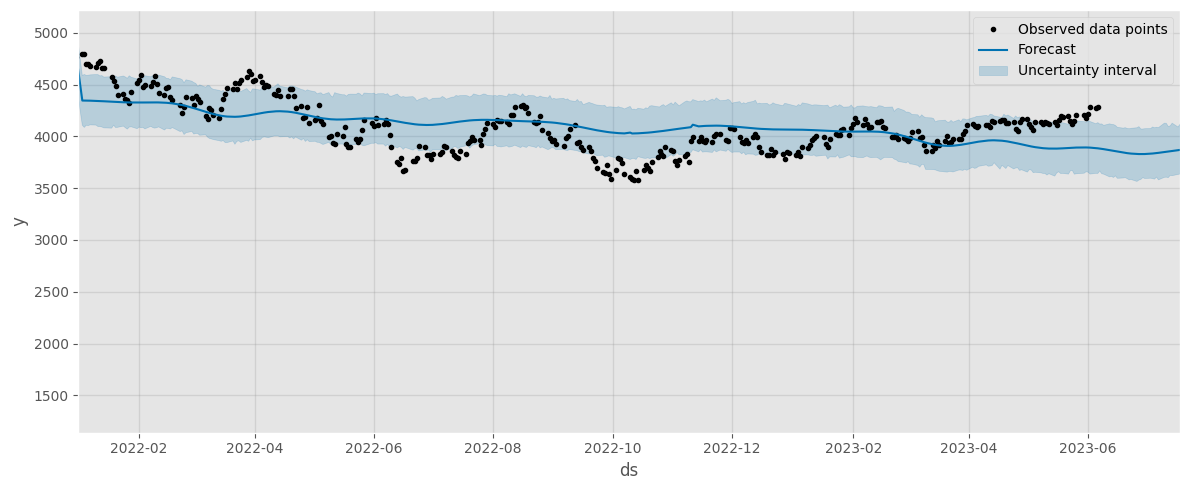

In [29]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast_best_season['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_best_season.plot(forecast_best_season, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

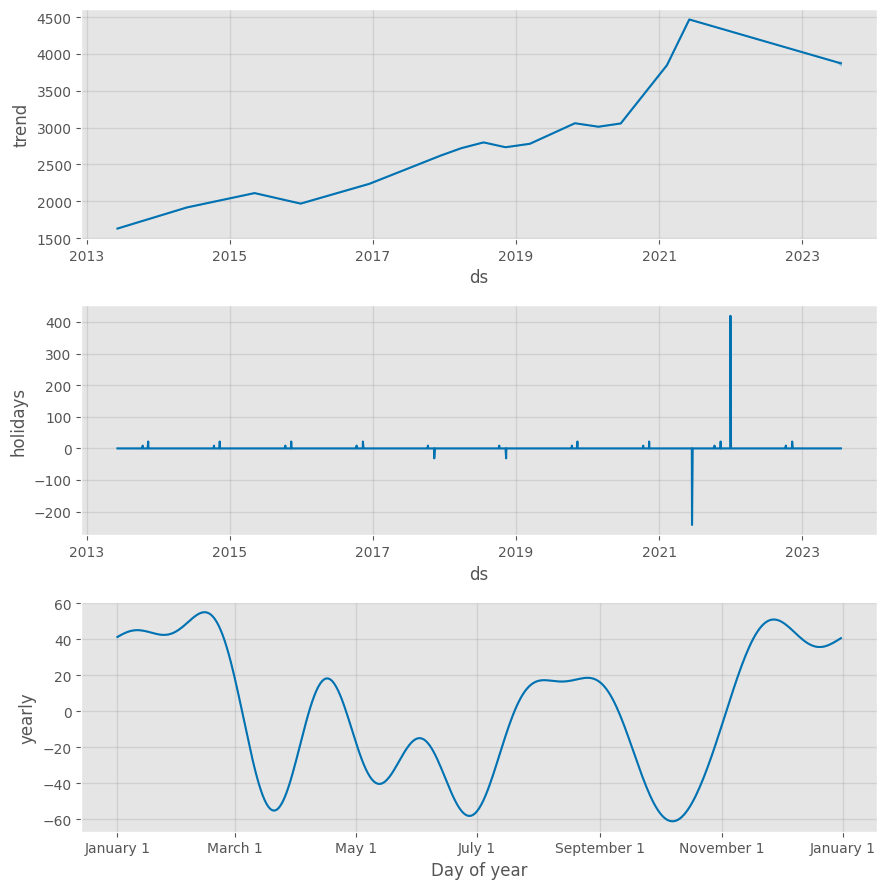

In [30]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model_best_season.plot_components(forecast_best_season)
plt.show()

In [31]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_season = cross_validation(model_best_season, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_season_perf = performance_metrics(forecast_cv_season)
forecast_season_perf.head()

CPU times: user 425 ms, sys: 65.1 ms, total: 490 ms
Wall time: 20.1 s


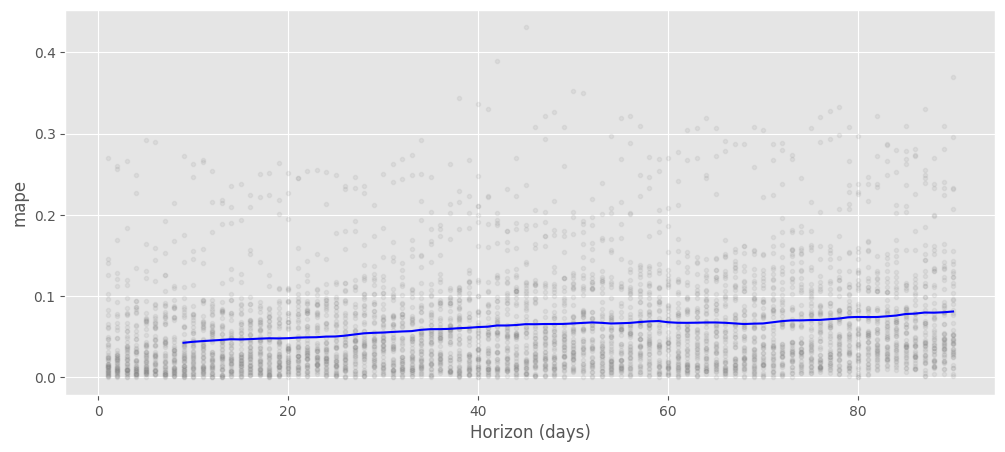

In [33]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_season, ax=ax, metric='mape')
plt.show()

In [38]:
# Create a DataFrame with information about COVID lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
# Convert the dates in the DataFrame to datetime objects
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
# Calculate the number of days between the start and end of each lockdown
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [39]:
%%time
# Create a Prophet model with best parameters from grid search, custom seasonality and include the lockdown information as holidays
model_covid = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, holidays=lockdowns)
model_covid.add_seasonality(name='yearly', period=365, fourier_order=8)
# Add US holidays
model_covid.add_country_holidays(country_name='US')
model_covid.fit(df_prophet)
forecast_covid = model_covid.predict(future)

12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.37 s, sys: 490 ms, total: 1.86 s
Wall time: 4.12 s


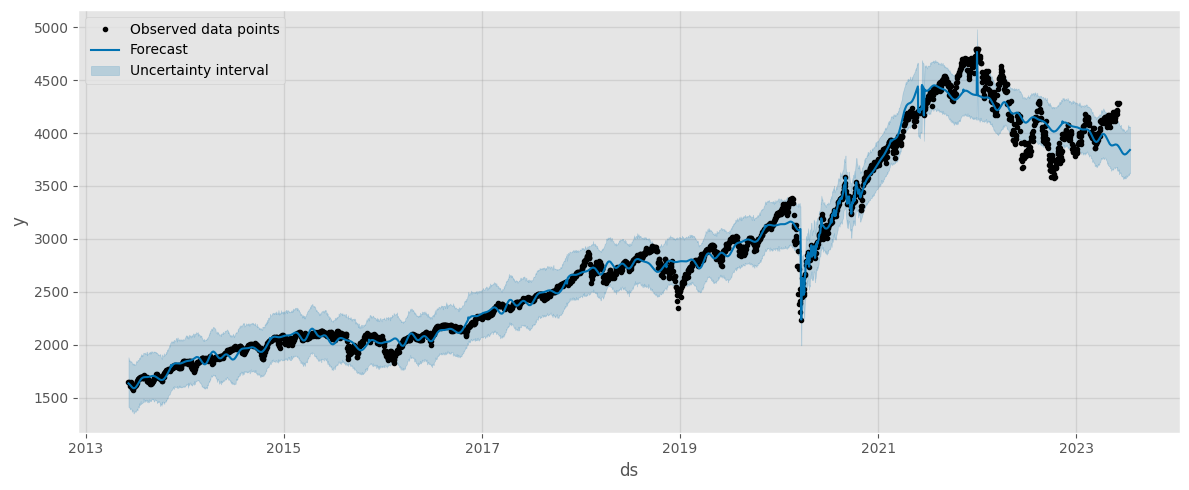

In [40]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model_covid.plot(forecast_covid, ax=ax, include_legend=True)
plt.show()

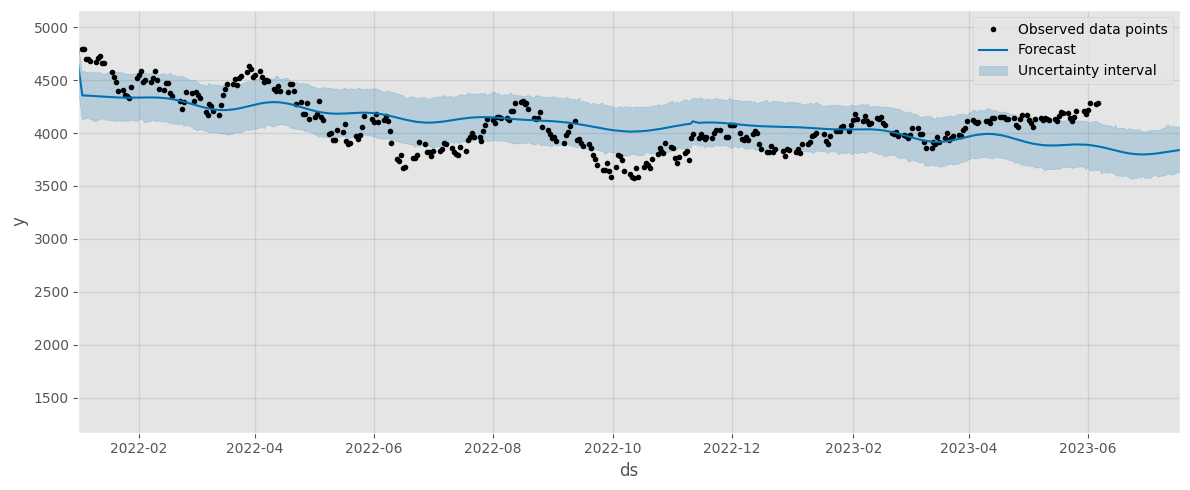

In [41]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast_covid['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_covid.plot(forecast_covid, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

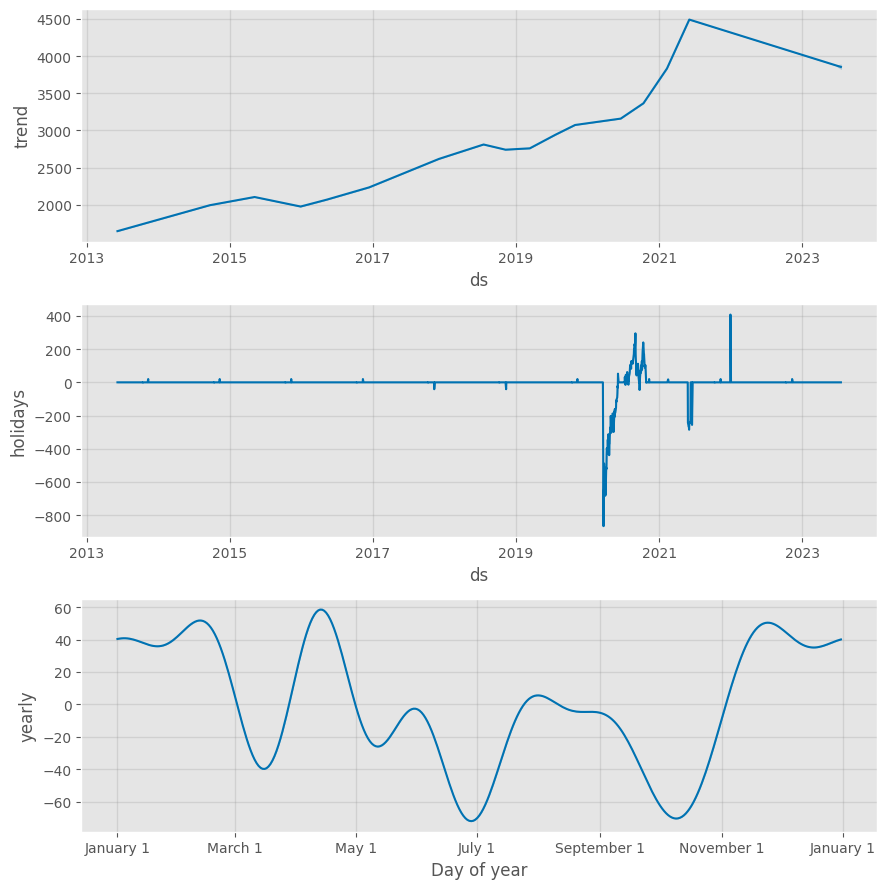

In [42]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model_covid.plot_components(forecast_covid)
plt.show()

In [48]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_covid = cross_validation(model_covid, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_covid_perf = performance_metrics(forecast_cv_covid)
forecast_covid_perf.head()

CPU times: user 387 ms, sys: 53 ms, total: 440 ms
Wall time: 1min 56s


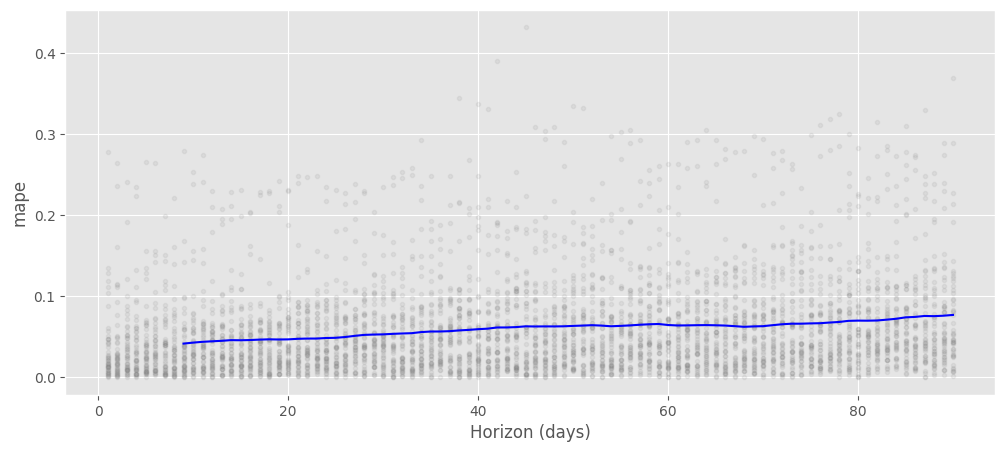

In [50]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_covid, ax=ax, metric='mape')
plt.show()